### Шарафетдинов Ринат Саярович

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

In [2]:
# Считываем трейн данные
train_clf = pd.read_csv('classify/train_clf.csv')

/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

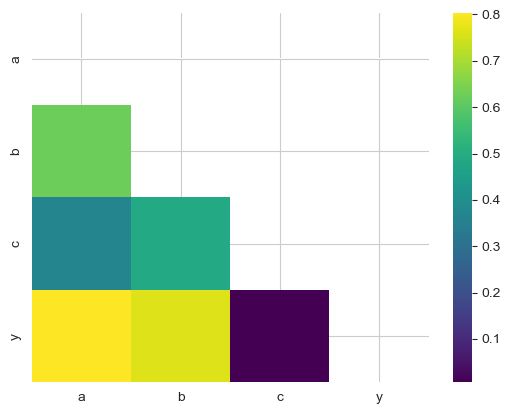

In [3]:
# Смотрим корреляцию признаков
corr = train_clf.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

### Переменные a и b хорошо коррелируют с таргетом, но переменная c вообще никак не коррелирует с таргетом, поэтому я его не буду использовать для прогноза.

In [4]:
columns = ['a', 'b']
X_train = train_clf[columns].values
y_train = train_clf['y'].values

In [5]:
X = train_clf[columns]
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

# Строим модель множественной логистической регресии
with pm.Model() as model_3:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.StudentT('β', mu=0, sigma=2, nu=50, shape=len(columns))
    μ = α + pm.math.dot( X_transform,β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_transform[:, 0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_train)
    trace = pm.sample(3500, chains = 4, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_500 draw iterations (4_000 + 14_000 draws total) took 17 seconds.
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [6]:
varnames = ['α','β','bd']
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.356,0.545,-1.399,0.667,0.005,0.004,11870.0,9692.0,1.0
β[0],-3.876,0.940,-5.639,-2.180,0.010,0.008,8528.0,8504.0,1.0
β[1],-3.404,0.848,-5.006,-1.876,0.009,0.007,8977.0,9664.0,1.0
θ[0],0.007,0.010,0.000,0.022,0.000,0.000,7482.0,7180.0,1.0
θ[1],0.000,0.000,0.000,0.000,0.000,0.000,7239.0,7157.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],0.900,0.294,0.412,1.473,0.002,0.002,16523.0,11449.0,1.0
bd[96],-0.578,0.236,-1.029,-0.158,0.002,0.001,13886.0,9981.0,1.0
bd[97],-0.915,0.312,-1.505,-0.370,0.003,0.002,14360.0,10702.0,1.0
bd[98],1.370,0.411,0.679,2.143,0.003,0.002,16795.0,11286.0,1.0


In [7]:
df = az.summary(trace, var_names=['α','β'] )
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.356,0.545,-1.399,0.667,0.005,0.004,11870.0,9692.0,1.0
β[0],-3.876,0.940,-5.639,-2.180,0.010,0.008,8528.0,8504.0,1.0
β[1],-3.404,0.848,-5.006,-1.876,0.009,0.007,8977.0,9664.0,1.0


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


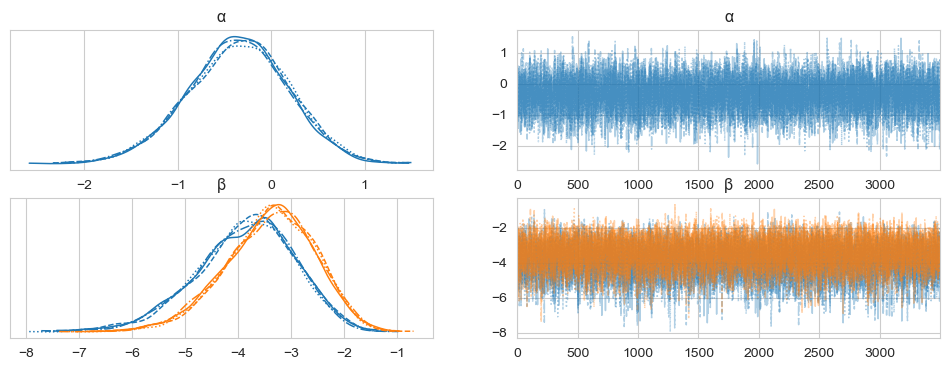

In [8]:
az.plot_trace(trace, var_names = ['α','β'],compact=True);

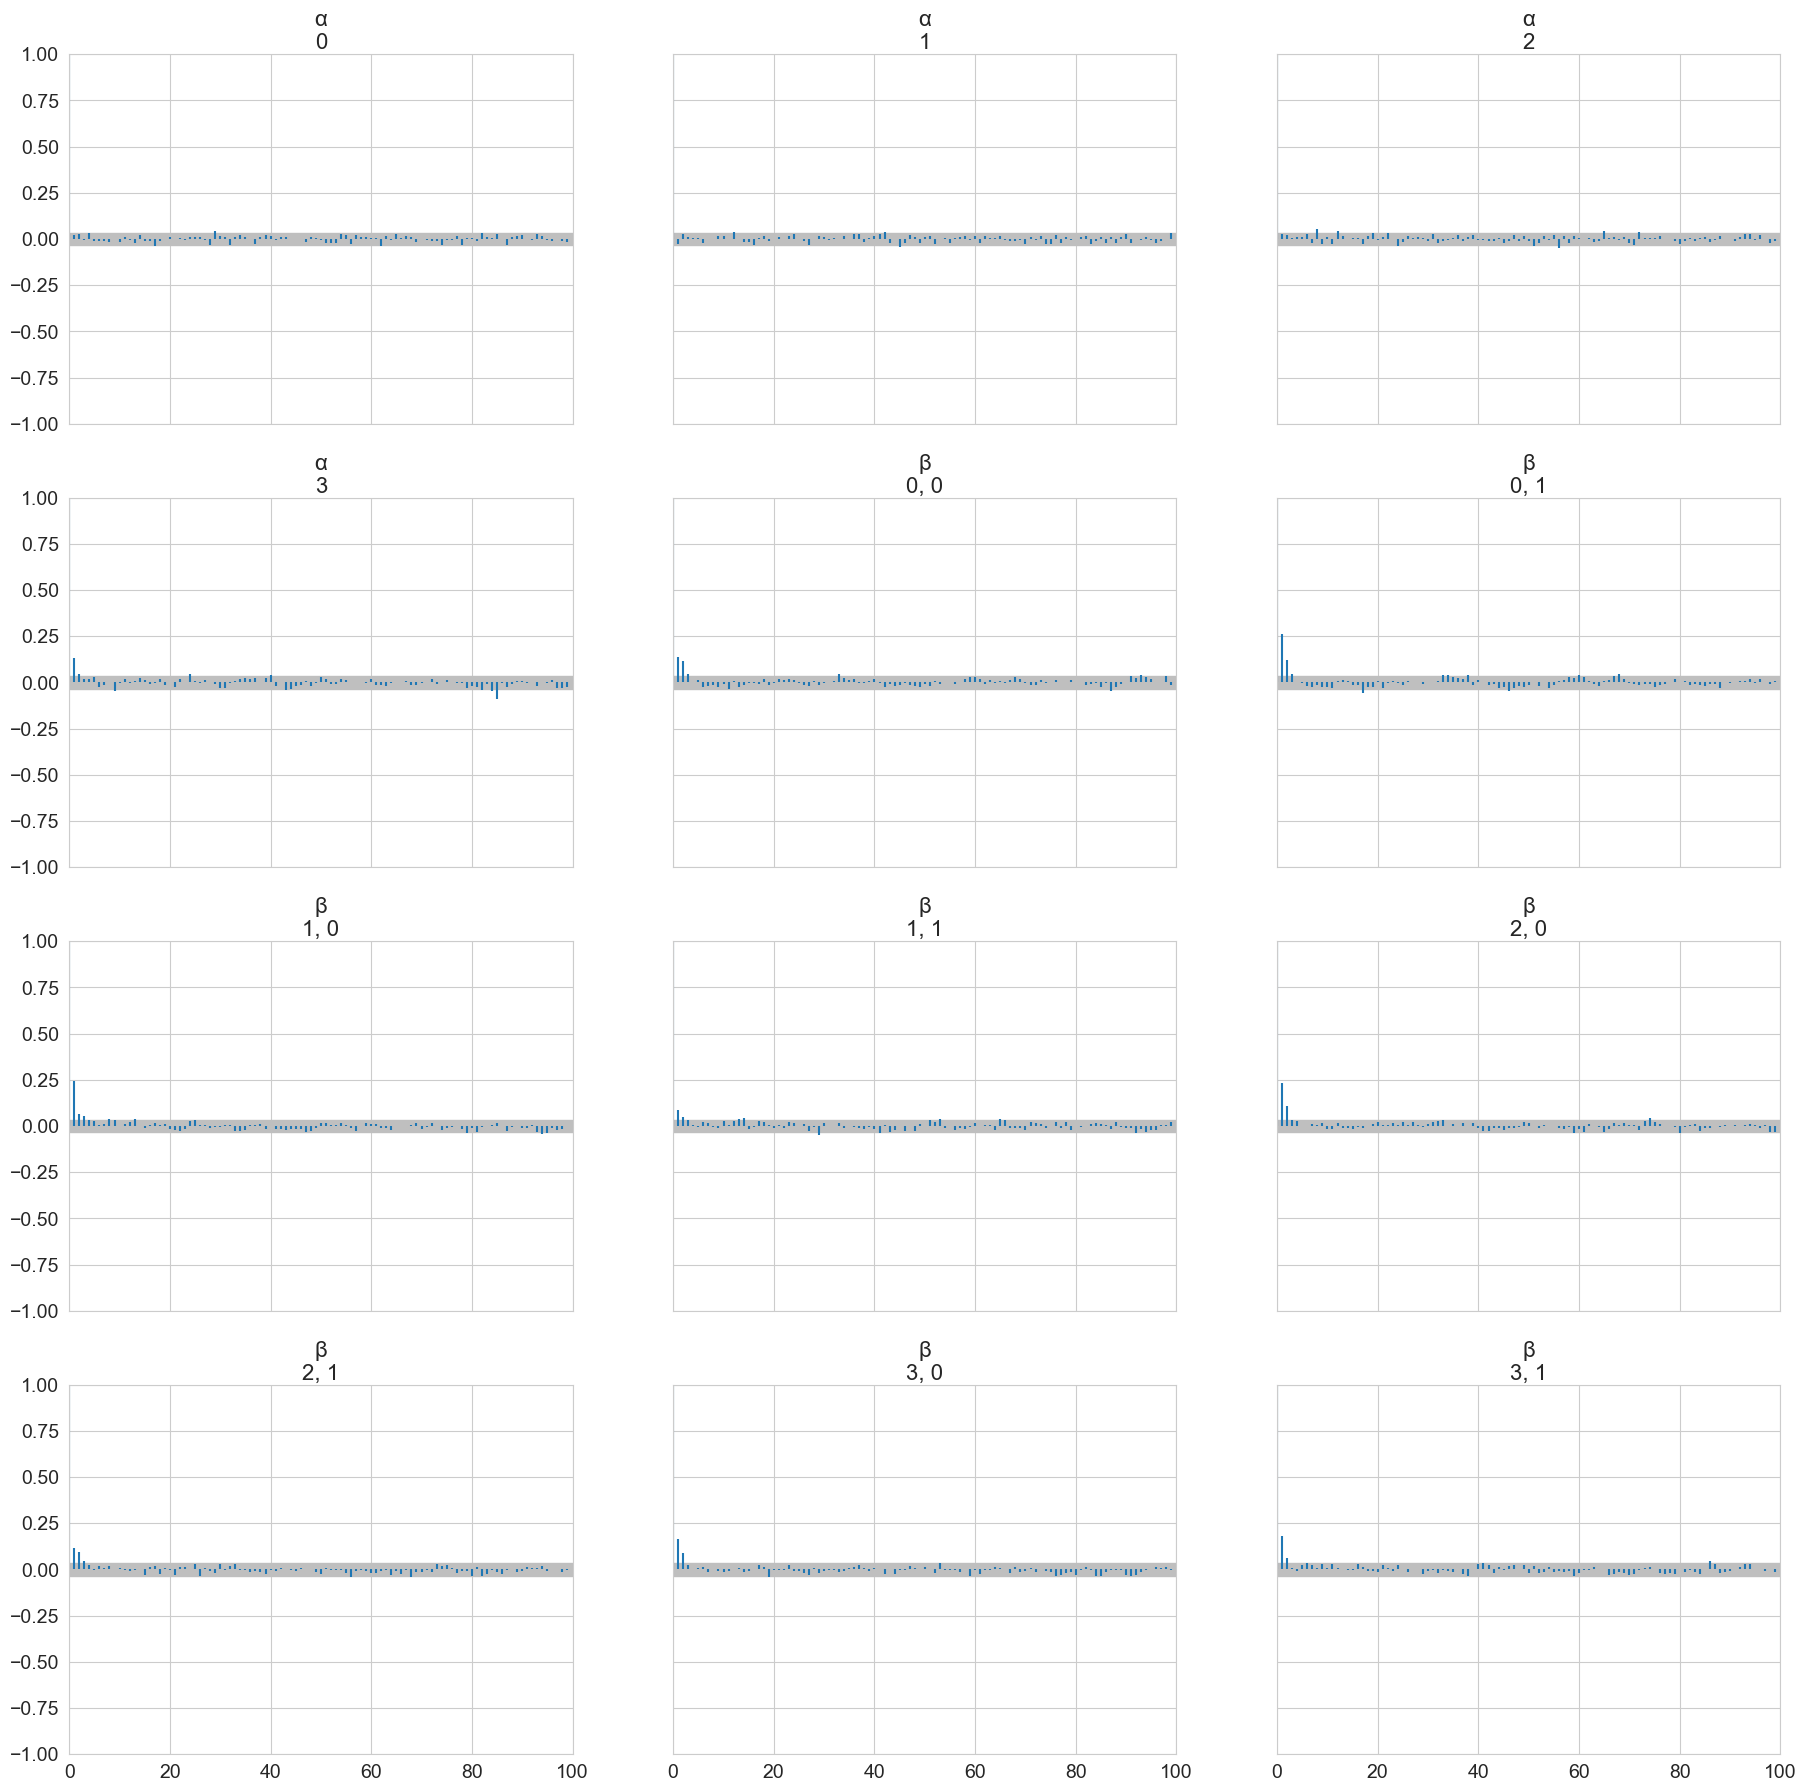

In [9]:
az.plot_autocorr(trace, ['α', 'β']);

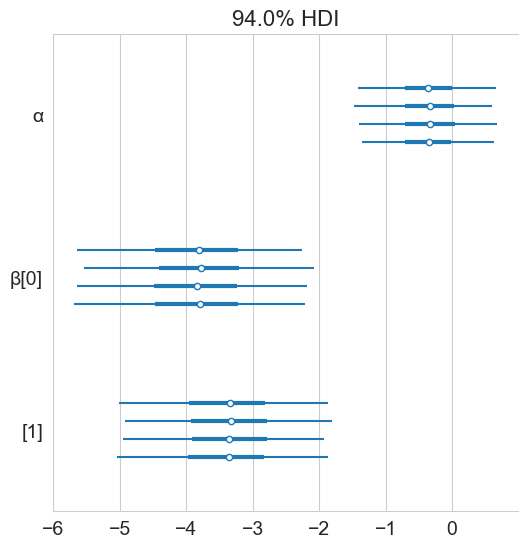

In [10]:
varnames = ['α', 'β']
az.plot_forest(trace, var_names=varnames);

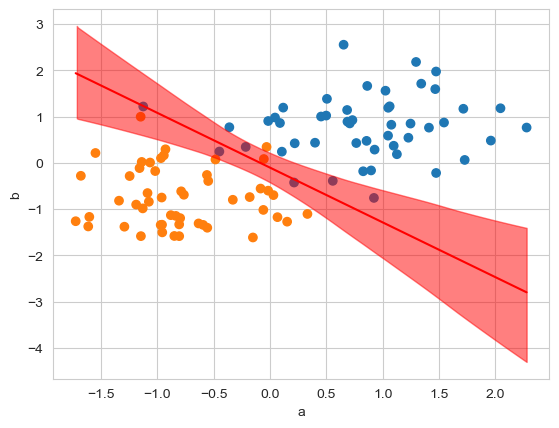

In [11]:
idx = np.argsort(X_transform[:,0])
bd = trace.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(X_transform[:,0], X_transform[:,1], c=[f'C{i}' for i in  y_train.astype(np.int8)])

plt.plot(X_transform[:,0][idx], bd, color='r');
az.plot_hdi(X_transform[:,0], trace.posterior['bd'], color='r')

plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

### Предсказываем на тестовых данных

In [12]:
# Загружаем тестовые данные
test_df = pd.read_csv('classify/test_clf.csv')
X_test = test_df[columns]
X_test_transformed = scaler.transform(X_test)


In [13]:
alpha = trace.posterior['α'].mean(("chain", "draw")).values
betta = trace.posterior["β"].mean(("chain", "draw")).values
z = alpha + np.dot(X_test_transformed, betta)
predicted_probabilities = 1 / (1 + np.exp(-z))
threshold = 0.5
predicted_labels = (predicted_probabilities > threshold).astype(int)


In [14]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, predicted_labels)

0.96

### Выполняем второй пункт задачи классификации

In [15]:
zeros = y_train==0
ones = y_train==1

In [16]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=1, sigma=18, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)

    one = pm.Normal('one', mu=μ[0], sigma=σ[0], observed=X_transform[zeros])
    two = pm.Normal('two', mu=μ[1], sigma=σ[1], observed=X_transform[ones])

    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_second = pm.sample(1000, chains = 4, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Text(0.5, 0, 'X')

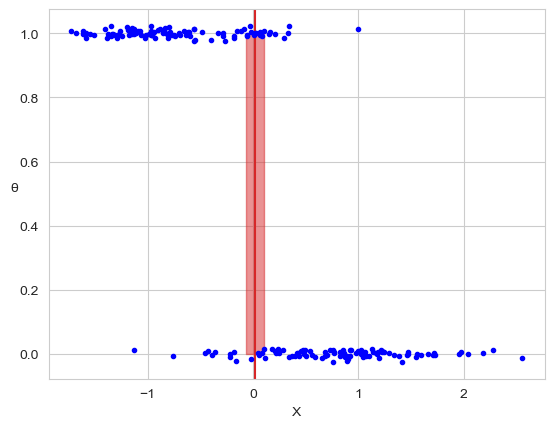

In [17]:
posterior_second = trace_second.posterior.stack(samples=("chain", "draw"))
plt.axvline(posterior_second['bd'].mean(), ymax=1, color='C3')

bd_hpd = az.hdi(posterior_second['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C3', alpha=0.5)

plt.plot(X_transform, np.random.normal(y_train, 0.01), '.', color='b')

plt.ylabel('θ', rotation=0)
plt.xlabel('X')

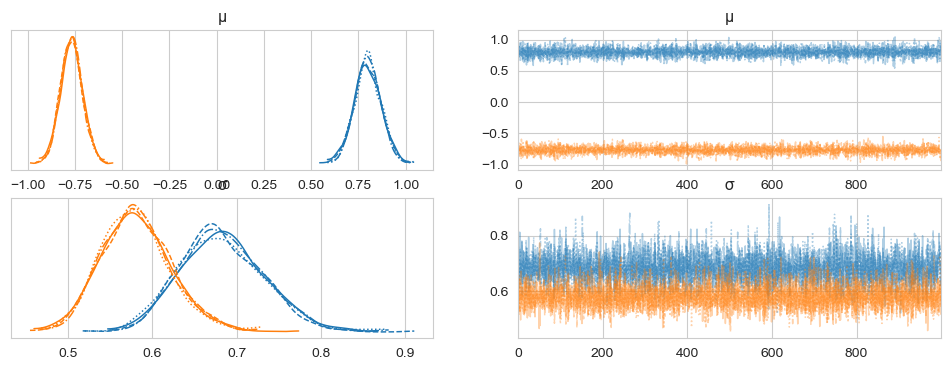

In [18]:
az.plot_trace(trace_second, var_names = ['μ','σ'],compact=True);

Text(0.5, 0, 'X')

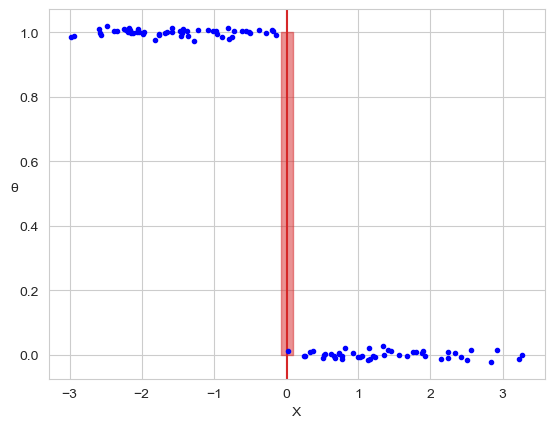

In [19]:
posterior_second = trace_second.posterior.stack(samples=("chain", "draw"))


plt.axvline(posterior_second['bd'].mean(), ymax=1, color='C3')
bd_hpd = az.hdi(posterior_second['bd'].values)


plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C3', alpha=0.5)

predicted_labels = [1 if i < posterior_second['bd'].mean() else 0 for i in X_test_transformed.sum(axis=1)]

plt.plot(X_test_transformed.sum(axis=1), np.random.normal(predicted_labels, 0.01), '.', color='b')

plt.ylabel('θ', rotation=0)
plt.xlabel('X')